# EDA on 3 Months Of Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Domain Knowledge

The goal of this project is to develop a model that can accurately predict fare prices.
Every single field can be analyzed to predict the fare price.
However, this is tedious and does not take into account domain knowledge.
Per the NYC Yellow Taxi Cab data dictionary, the fare amount is calculated by fare distance and duration.
This means certain types of fields can be ignored.

For example, the day of the week or day of the year has no impact on fare prices.
Any tolls or surchages are not factored into the fare amount itself, but added to the total amount that passengers pay.
Thus, most time-based features will not be considered.
Additionally, location information is also largely irrelevant.
Where passengers are picked up and dropped off in regards to location information is not useful, since the trip distance is more relevant that what PU Location ID is specified for a specific record.

This means the fields can be reduced to those more relevant from a domain knowledge perspective.
The rate code ID, trip distance, trip duration fields are obviously the most important fields.

From the NYC Government website aboute standard metered fare:

* $3.00 initial charge.
* Plus 70 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
* Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
* Plus $1.00 Improvement Surcharge.
* Plus $1.00 overnight surcharge 8pm to 6am.
* Plus $2.50 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
* Plus New York State Congestion Surcharge of $2.50 (Yellow Taxi) or $2.75 (Green Taxi) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
* Plus MTA Congestion Pricing toll of 75 cents for Yellow and Green Taxi for the area of Manhattan south of and including 60th Street, excluding the FDR Drive, West Side Highway/Route 9A, and the Hugh L. Carey Tunnel connections to West Street. For more information on the MTA’s Congestion Pricing toll, please visit: : https://new.mta.info/tolls/congestion-relief-zone/taxi-fhv-tolls
* Plus tips and any tolls.
* There is no charge for extra passengers, luggage or bags, or paying by credit card.
* The on-screen rate message should read: "Rate #01 – Standard City Rate."

The challenge with this project is the data does not include specific information to make a perfect calculation. Additionally, when someone wants to predict the standard metered fare amount, they would not know the exact information to compute the fare amount.

The fare amount can be calculated as such:

Fare Amount = $3.00 + $0.7 * N + $0.7 * M

where N = # of 1/5 miles traveling above 12 MPH and M = # of minutes traveling at a rate <= 12 MPH

Furthermore:

Distance = N + # of 1/5 miles traveling at a rate <= 12 MPH

N = Distance - # of 1/5 miles traveling at a rate <= 12 MPH

But this can be expressed as a fraction:

N = c_1 * Distaance

Where c_1 is the proportion of the distance that was travelled at a rate > 12 MPH

Likewise with the Duration:

Duration = M + # of minutes traveling at a rate > 12 MPH

M = c_2 * Duration

Where c_2 is the proportion of the duration that was travelled at a rate <= 12 MPH

Finally:

Fare Amount = $3.00 + $0.7 * c_1 * N + $0.7 * c_2 * M

Fare Amount = $3.00 + $0.7 * (c_1 * N + c_2 * M)

Alternatively, we can simply flip the variables and have c_1 and c_2 be the proportion of the trip distance and duration, respectively, that count towards the fare.

Fare Amount = $3.00 + $0.7 * (c_1 * Distance + c_2 * Duration)

Thus, the fare amount has a linear relationship with the proportions of trip distance and trip duration.

As states above, the challenge is that the proportions, c_1 and c_2 are not present or can be calculated in the data, nor would this knowledge be known for someone evaluating the taxi cab fare until the fare was completed. It's fair to say that c_1 and c_2 vary by inidivudal taxi cab fares, thus a linear relationship may not be directly discernable from analyzing trip durations and trip distances to the fare amount.

In [ ]:
df = pd.read_parquet("/home/joe/datum/fare_amount_init_6_8_2023.parquet")

In [3]:
df.columns

Index(['pu_month', 'pu_year', 'pu_year_month', 'trip_distance',
       'trip_duration_min', 'fare_amount'],
      dtype='object')

In [4]:
# Let's add in the average travel rate
df["travel_rate"] = df["trip_distance"] / (df["trip_duration_min"] / 60)

In [5]:
target = "fare_amount"
numeric_feats = ["trip_distance", "trip_duration_min", "travel_rate"]

In [6]:
df = df[numeric_feats + [target]]

## Exploring the Target (Fare Amount)

count    7.785073e+06
mean     1.653345e+01
std      1.131523e+01
min      3.000000e+00
25%      9.300000e+00
50%      1.280000e+01
75%      1.980000e+01
max      7.000000e+01
Name: fare_amount, dtype: float64
Lower Outlier Limit : -6.449999999999999
Upper Outlier Limit : 35.55


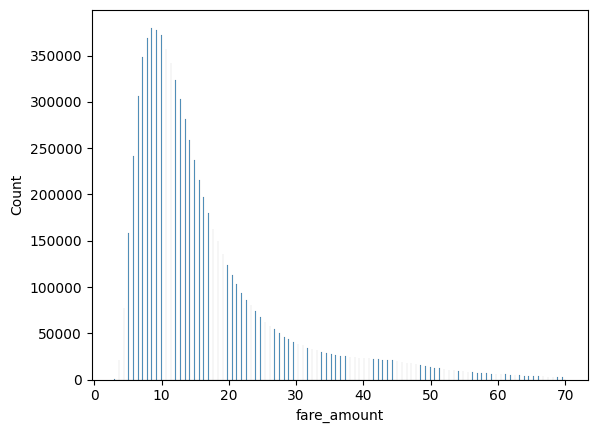

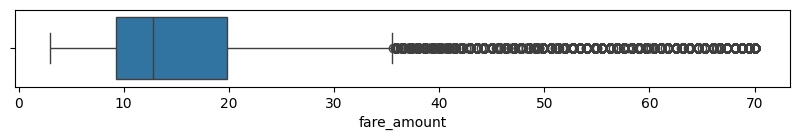

In [7]:
feat = target
summary = df[feat].describe()
print(summary)
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

## Exploring Numeric Features

### Trip Distance

count    7.785073e+06
mean     2.731972e+00
std      2.799552e+00
min      1.000000e-02
25%      1.070000e+00
50%      1.740000e+00
75%      3.070000e+00
max      2.770000e+01
Name: trip_distance, dtype: float64 

Lower Outlier Limit : -1.9299999999999995
Upper Outlier Limit : 6.069999999999999


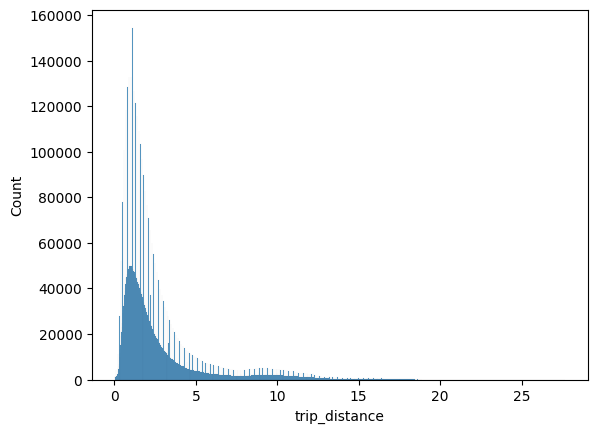

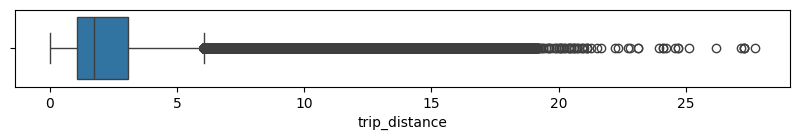

In [8]:
feat = "trip_distance"
summary = df[feat].describe()
print(summary, "\n")
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

## Trip Duration (Minutes)

count    7.785073e+06
mean     1.423888e+01
std      9.427467e+00
min      1.016667e+00
25%      7.433333e+00
50%      1.191667e+01
75%      1.858333e+01
max      8.993333e+01
Name: trip_duration_min, dtype: float64 

Lower Outlier Limit : -9.291666666666664
Upper Outlier Limit : 35.30833333333333


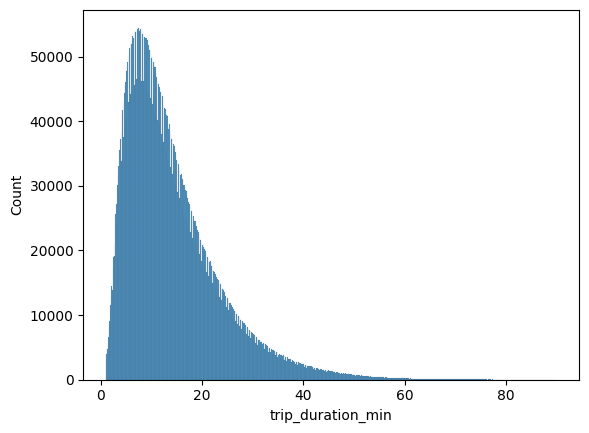

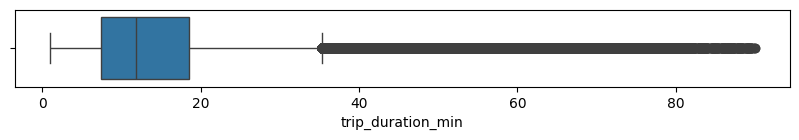

In [9]:
feat = "trip_duration_min"
summary = df[feat].describe()
print(summary, "\n")
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

### Travel Rate

count    7.785073e+06
mean     1.095851e+01
std      5.781328e+00
min      1.346801e-02
25%      7.337580e+00
50%      9.712707e+00
75%      1.296418e+01
max      1.205714e+03
Name: travel_rate, dtype: float64 

Lower Outlier Limit : -1.1023239467015298
Upper Outlier Limit : 21.4040855587276


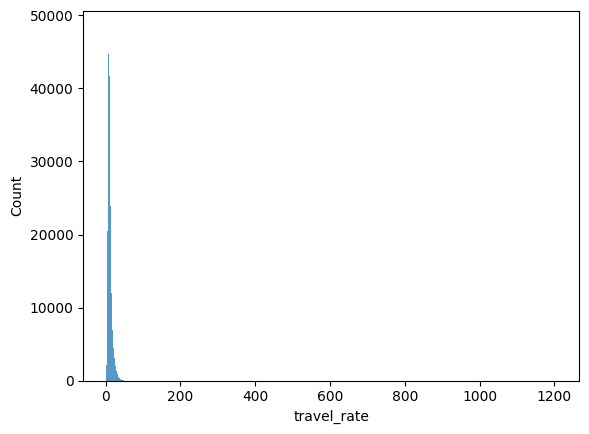

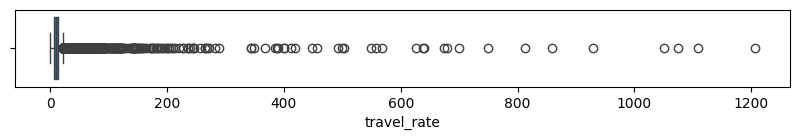

In [10]:
feat = "travel_rate"
summary = df[feat].describe()
print(summary, "\n")
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

## Numeric Feature - Target Relationships

### Correlations

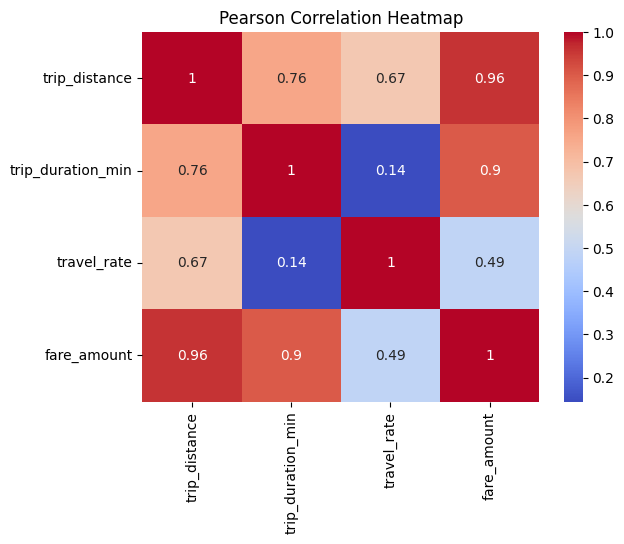

In [11]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')
plt.show()

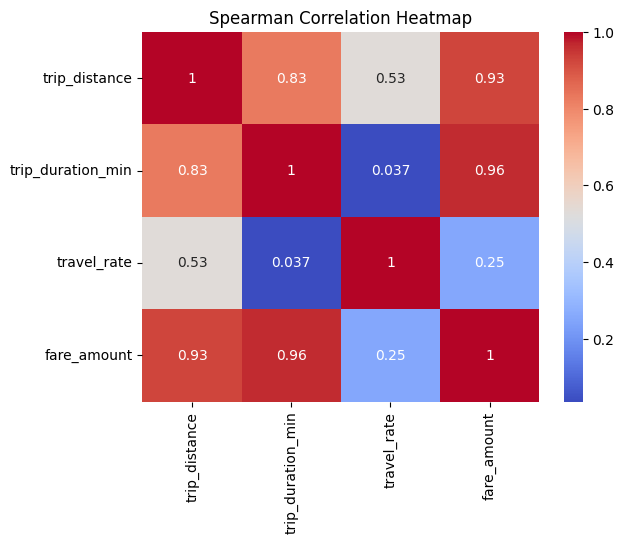

In [12]:
correlation_matrix = df.corr(method="spearman")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()

### Trip Distance

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

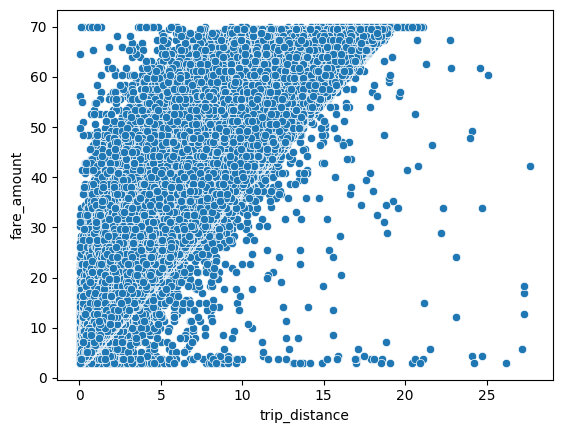

In [13]:
sns.scatterplot(data=df, x="trip_distance", y=target)

### Trip Duration

<Axes: xlabel='trip_duration_min', ylabel='fare_amount'>

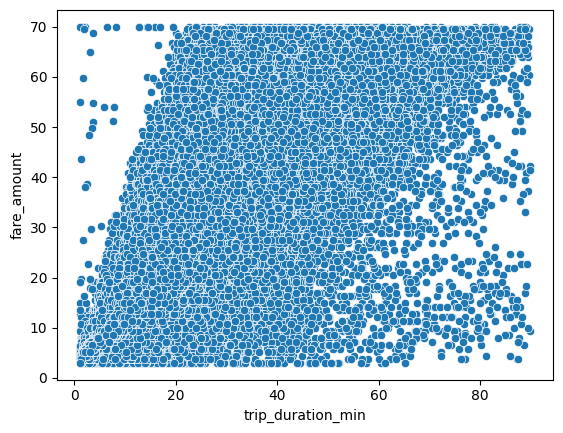

In [14]:
sns.scatterplot(data=df, x="trip_duration_min", y=target)

### Trip Distance + Trip Duration

In [15]:
df["dist_dur"] = df["trip_distance"] + df["trip_duration_min"]

<Axes: xlabel='dist_dur', ylabel='fare_amount'>

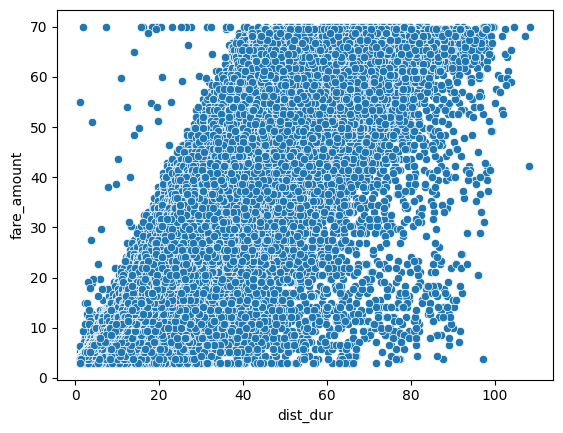

In [16]:
sns.scatterplot(data=df, x="dist_dur", y=target)

## Findings

The fare amount, trip distance, and trip duration all appear to be gamma distributed.
For trip durations, this is especially expected.
Most taxi cab rides tend to be short: about 11 minutes in duration and under 2 miles in total trip distance.

Scatter plots of trip distance vs fare amount and trip duration vs fare amount do not show distinct patterns.
This is because of the variability of the proportion of the trip distance and trip duration factor into the fare amount equation.